In [5]:
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random 
from scipy.interpolate import RBFInterpolator
from scipy.spatial import KDTree
import numba 

random.seed(0)
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Problem Statement

We define the problem in terms of supervised learning. Consider a dataset of $N$ points with $f$ features with two classes, one denoting the point as "unhealthy" and the other denoting the point as "healthy." 

We apply an AI model (model-agnostic) such that the model learns a decision boundary or contour between the two classes. 

For the problem, we want to find the closest distance from any given unhealthy point to the decision boundary. We mean that among all points in the decision boundary, what point in the boundary will be closest to the point? 

Additionally, given a set of constraints in $f$ dimensions or fewer, what is the closest point satisfying the constraints to the decision boundary? If constraints are defined for all $f$ dimensions, there would be a box around the original "unhealthy" point. What point lies on the box which is closest to the decision boundary?

# Goals for the Problem Statement 

1. Find the Decision Boundary for any model defined on a dataset of $N$ points with $f$ within the binary classification case. Finding the Decision Boundary must be model-agnostic and must work for any dataset (invariant to the number of features and data points). 
2. We must find the closest distance from a given unhealthy data point (from 1.) to the decision boundary. This must work in any Euclidean space of dimension $R^f$ so that it can work with any dataset. 
3. Given a set of constraints in $f$ dimensions or fewer, what is the closest point satisfying the constraints to the decision boundary? We will show examples in 2D. 

# Importing the Dataset and Creating the Model

Below, we import the SVM dataset into the Juypter Notebook. This dataset consists of $20$ points which are one of two classes, either "healthy" or "unhealthy." The "unhealthy" points are colored red whereas the healthy points are colored blue.

We create an svm classifier that we use to apply to the SVM dataset.

In [6]:
# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

# Visualizing the Dataset

Below, we show a visualization of the dataset on two features ($x_1$ and $x_2$), and we label each of the data points as one of two classes ("healthy" or "unhealthy")

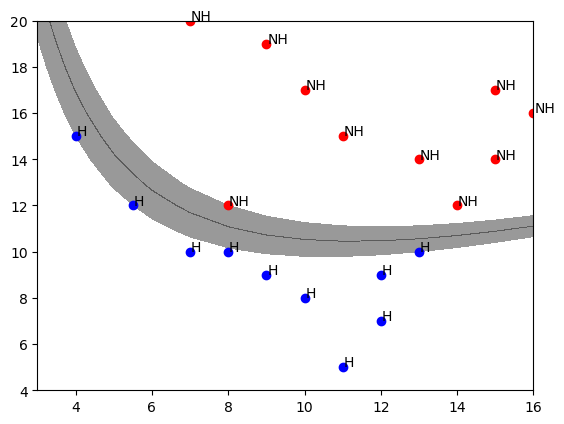

In [9]:
X1=df['x1']
X2=df['x2']
X_train=np.array(list(zip(X1,X2)))
y_train=df['y'].values
# svm_classifier = svm.SVC(kernel='linear', C=10)
#svm_classifier = svm.SVC(kernel='poly', C=10)
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)
svm_classifier.fit(X_train, y_train)
color_ls = []
for k in y_train:
    if k == 1:
        color_ls.append('b')
    else:
        color_ls.append('r')
color_ls
label = []
for k in y_train:
    if k == 1:
        label.append('H')
    else:
        label.append('NH')
label
def plot_decision_boundary(clf, X, y):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max),np.arange(x2_min, x2_max))
    Z = clf.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    m = np.nonzero(Z < -19)
    Q = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, colors='k', levels=[-1, 0, 1], alpha=0.4,linestyles=['--', '-', '--'])
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
plot_decision_boundary(svm_classifier, X_train, y_train)

for k, (i,j) in enumerate(X_train):
    plt.scatter(i, j, c = color_ls[k])
    plt.text(i+0.02, j+0.02, label[k])

# Closest Point Functions 

```closest_point()``` - computes the closest distance from a point in $R^f$ from the decision boundary usually defined as an numpy array of points in $R^f$ where $f$ is the number of features 

```closest_border_point``` - This computes the closest distance from a set of border points from the decision boundary. Border points are defined with constraints around the original unhealthy point. If we generate a box around an unhealthy point, this will determine the closest distance from the box to the decision boundary.

In [3]:
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    if not isinstance(closest_index, np.int64): 
        closest_index = closest_index[0]
    closest_point = contour[closest_index]
    return closest_point

def closest_border_point(border_points, contour): 
    # Build a KDTree for fast nearest neighbor search
    tree = KDTree(contour) 

    min_point, total_min = None, float('inf')

    for border_point in border_points: 
        # Find the distance and index of the closest contour point using KDTree
        dist, _ = tree.query(border_point)

        # Update the minimum point and distance if a closer point is found
        if dist < total_min: 
            total_min = dist 
            min_point = border_point 
    
    return min_point

# Displacement Function 

```move_from_A_to_B_with_x1_displacement()``` - moves from a given point A to another point B with a displacement value delta 

In [4]:
def move_from_A_to_B_with_x1_displacement(A, B, deltas):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = deltas / D  # D[0] is the x1 component of the direction vector
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

[0.5 0.5 0.5]
[3 3 3]
New point P with desired x1 movement: [2.5 3.5 4.5]


# Finding Decision Boundary Points

```compute_decision_boundary_points_all_features()``` -- computes the decision boundary points from a generated meshgrid of points 

```prediction()``` -- Looks for the midpoint between two classes and appends them to a list consisting of boundary points

In [5]:
@numba.njit 
def prediction(Z, grid, epsilon): 
    boundary_points = [] 
    for i in range(len(grid) - 1):
            for j in range(i + 1, len(grid)):
                if np.linalg.norm(grid[i] - grid[j]) < epsilon and Z[i] != Z[j]:
                    boundary_points.append((grid[i] + grid[j]) / 2)  # Midpoint between two classes
    return boundary_points

def compute_decision_boundary_points_all_features(model, X, resolution=100, epsilon=0.01):
    """
    Compute decision boundary points in the high-dimensional feature space.
    Args:
        model: Trained classifier.
        X: Input data (n_samples, n_features).
        resolution: Number of points to sample along each feature axis.
        epsilon: Small step size to detect class changes.
    Returns:
        boundary_points: Array of points near the decision boundary.
    """
    n_features = X.shape[1]
    grid = np.zeros((resolution ** n_features, n_features))
    for i in range(n_features):
        grid[:, i] = np.tile(np.linspace(X[:, i].min() - 1, X[:, i].max() + 1, resolution).repeat(resolution ** (n_features - i - 1)), resolution ** i)
    # Predict the class for each point in the grid
    Z = model.predict(grid)
    # Find points near the decision boundary
    boundary_points = prediction(Z, grid, epsilon)
 
    return np.array(boundary_points)

# Interpolation, Generating boundaries for a n-dimensional cube 

- RBF Interpolation used for interpolating scattered data points

```multi_dim_interpolator()``` -- returns an interpolator based on RBF interpolation 

```get_multi_dim_border_points()``` -- generates points on the boundaries of an n-dimensional hyperrectangle / cube 

In [6]:
def multi_dim_interpolator(boundary_points, N=10000): 
    n_features = boundary_points.shape[1]
    X_vals, y_vals = boundary_points[:N,0:n_features-1], np.reshape(boundary_points[:N,-1], (-1,1)) 
    interpolator = RBFInterpolator(X_vals, y_vals, kernel='cubic', smoothing=1e-2)
    return interpolator 

def generate_add_boundary_pts(X, N=25): 
    n_features = X.shape[1]
    ranges = [np.linspace(X.iloc[:, j].min()-1, X.iloc[:, j].max()+1, N) for j in range(n_features-1)]
    grid_points = np.vstack([r.ravel() for r in ranges]).T
    return grid_points 

def get_multi_dim_border_points(center, extents, step=0.1):
    """
    Generate points on the boundaries of an n-dimensional hyperrectangle.
    
    Parameters:
    - center: List or array of length n, the center of the hyperrectangle.
    - extents: List or array of length n, the half-widths in each dimension.
    - step: Float, step size for sampling points along each dimension.
    
    Returns:
    - List of tuples, each tuple representing a point on the boundary.
    """
    center = np.array(center)
    extents = np.array(extents)
    n = len(center)  # Number of dimensions
    points = set()   # Use set to avoid duplicates
    
    # Define min and max bounds for each dimension
    bounds = [(c - e, c + e) for c, e in zip(center, extents)]
    
    # For each dimension, generate points on the lower and upper boundaries
    for dim in range(n):
        # For lower and upper boundary in this dimension
        for bound_val in [bounds[dim][0], bounds[dim][1]]:
            # Generate grid points for all other dimensions
            other_dims = [i for i in range(n) if i != dim]
            ranges = [np.arange(bounds[i][0], bounds[i][1] + step, step) for i in other_dims]
            if not ranges:  # Handle 1D case
                points.add(tuple([bound_val] if dim == 0 else []))
                continue
            # Create meshgrid for other dimensions
            grids = np.meshgrid(*ranges, indexing='ij')
            coords = [grid.ravel() for grid in grids]
            
            # Construct points
            for coord in zip(*coords):
                point = [0] * n
                # Set the current dimension to the boundary value
                point[dim] = bound_val
                # Set other dimensions to the grid values
                for i, val in zip(other_dims, coord):
                    point[i] = val
                points.add(tuple(point))
    
    return list(points)

def det_constraints(datapt, changes): 
    constraints = [-1] * len(changes) 
    len_constr = 0 
    for i in range(len(changes)): 
        if type(changes[i]) == float or type(changes[i]) == int:
            constraints[i] = (changes[i]/100)*datapt[i]
            len_constr+=1
    return constraints, len_constr

def constraint_bounds(contours, datapt, constraints): 
    if len(constraints) == 0: 
        raise Exception("No constraints were assigned.")
    bounded_contour = contours.copy() 
    for i in range(len(constraints)): 
        if constraints[i] > 0:
            x = datapt[0][i]
            # This should just be the delta
            delta_x = constraints[i]
            # Generate a lower and upper bounds on each constraint
            lowb_x, highb_x = x - (delta_x / 2), x + (delta_x / 2)
            contour_arr = bounded_contour[:, i]
            # Choose the correct indices for the multi-dimensional df
            indices = np.where((contour_arr >= lowb_x) & (contour_arr <= highb_x))
            bounded_contour_pts = bounded_contour[indices]
            bounded_contour = bounded_contour_pts
            if i == 0:
                plt.axvline(x=highb_x, color='b', linestyle='-', label='High Bound x')
                plt.axvline(x=lowb_x, color='b', linestyle='-', label='Low bound x')
            else: 
                plt.axhline(y=highb_x, color='b', linestyle='-', label='High Bound y')
                plt.axhline(y=lowb_x, color='b', linestyle='-', label='Low bound y')
    return bounded_contour

# Generating the optimal point

```optimal_point()``` -- generates the boundary point closest to a given "undesired" coordinates (unhealthy point); if given a constraint, it will find the closest point from the box to the contour and/or look for the closest point to the contour depending on selected constraints

1. Fits on the dataset 
2. Computes the decision boundary points from the given fitted model and the provided dataset
3. Finds the closest boundary point from the undesired data point (unhealthy data point)

In [7]:
# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(dataset, model, desired_class, undesired_coords, resolution=100, point_epsilon=0.1, epsilon=0.01, changes=[]): 
    
    X_train, y_train = dataset.iloc[:, 0:dataset.shape[1]-1], dataset.iloc[:, -1]
    n_features = X_train.shape[1]

    print("fitting model...")
    model.fit(X_train, y_train)
    print("model finished.")

    # Generate points on multi-dimensional contour
    print("boundary points started generation...")
    boundary_points = compute_decision_boundary_points_all_features(model, X_train.to_numpy(), resolution=resolution, epsilon=point_epsilon)
    print("boundary points finished.")
    print(boundary_points.shape)
    contours = np.unique(boundary_points, axis=0)

    probs = model.predict_proba(contours)
    average_diff = np.mean(probs[:, 0] - probs[:, 1])
    print("Average difference:", average_diff)
    print(contours.shape)
    # print("Generating the final contour for multi-dimensional interpolation finished.")
    # contours = boundary_points
    undesired_datapt = np.reshape(np.array(list(undesired_coords)), (1, -1))
    # Find the closest point from the undesired point to the contour line
    print("Finding the closest point from the contour line to the point...")
    optimal_datapt = closest_point(undesired_datapt, contour=contours)
    print("Finding the closest point from the contour line to the point.")
    plt.plot(contours[:,0], contours[:,1], lw=0.5, color='black')

    if desired_class == 1: 
        D = optimal_datapt - undesired_datapt
        deltas = D * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, deltas=deltas)
    elif desired_class == -1: 
        closest_boundedpt = None
        constraints, len_constr = det_constraints(datapt=undesired_datapt[0], changes=changes)
        bounded_contour_pts = None
        #print(undesired_datapt.shape)
        if len_constr > n_features: 
            raise Exception("There cannot be more constraints than features")
        elif len_constr == n_features:
            bounded_contour_pts = get_multi_dim_border_points(center=undesired_datapt[0], extents=constraints, step=0.05)
            np_bounded_contour = np.array(bounded_contour_pts)
            x_values, y_values = np_bounded_contour[:,0], np_bounded_contour[:, 1]
            plt.scatter(x_values, y_values, marker='o')
            closest_boundedpt = closest_border_point(bounded_contour_pts, contour=contours)
        else: 
            # Generate bounded contour points
            bounded_contour_pts = constraint_bounds(contours, undesired_datapt, constraints)
            closest_boundedpt = closest_point(point=undesired_datapt, contour=bounded_contour_pts)

        D = closest_boundedpt - undesired_datapt
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, closest_boundedpt, deltas=D)
    plt.scatter(undesired_datapt[0][0], undesired_datapt[0][1], c = 'r')
    plt.text(undesired_datapt[0][0]+0.002, undesired_datapt[0][1]+0.002, 'NH')
    plt.scatter(optimal_datapt[0][0], optimal_datapt[0][1], c = 'r')
    plt.text(optimal_datapt[0][0]+0.002, optimal_datapt[0][1]+0.002, 'NH')
    plt.plot([undesired_datapt[0][0], optimal_datapt[0][0]], [undesired_datapt[0][1],optimal_datapt[0][1]], linestyle='--')
    return optimal_datapt

# An example of applying the optimal point function 

We apply the optimal point function with the given dataset using a fitted SVM classifier. We return the closest point on the decision boundary from the given unhealthy point.

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(3900, 2)
Average difference: -0.28020312698784194
(2705, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1.07 1.07]]
[[-0.53868195 -4.47277937]]


array([[10.42361032, 10.21412607]])

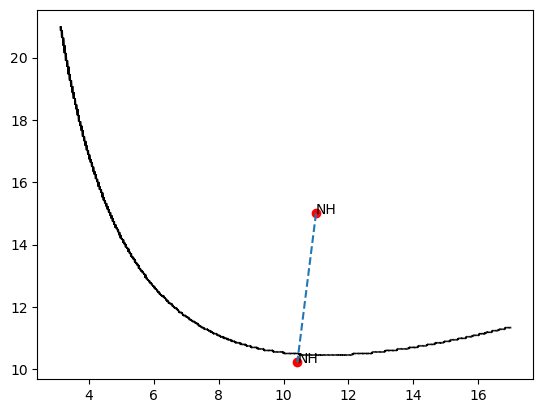

In [ ]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=1, resolution=350, undesired_coords=(11,15), point_epsilon=0.1, epsilon=0.07)
optimal_projection

# Setting Constraints on Each Dimension 

Below, we define the dataset on an SVM classifier where we specify constraints on each dimension.

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(1666, 2)
Average difference: -0.26206655271404783
(1401, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1. 1.]]
[[-1.65 -2.25]]


array([[ 9.35, 12.75]])

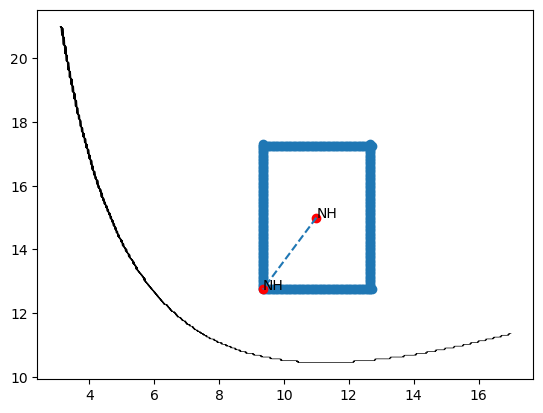

In [9]:
optimal_projection = optimal_point(df, svm_classifier, resolution=300, undesired_coords=(11,15), desired_class=-1, point_epsilon=0.1, epsilon=0.01, changes=[15,15])
optimal_projection

# Defining in $N$ or fewer dimensions 

Below, we define constraints for a single dimension while letting the other constraint run free.

fitting model...
model finished.
boundary points started generation...
boundary points finished.
(1666, 2)
Average difference: -0.2835905712976492
(1401, 2)
Finding the closest point from the contour line to the point...
Finding the closest point from the contour line to the point.
[[1. 1.]]
[[-5.7993311  -1.10702341]]


array([[ 5.2006689 , 13.89297659]])

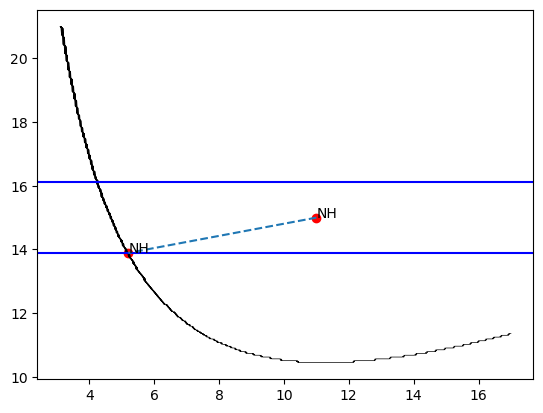

In [10]:
optimal_projection = optimal_point(df, svm_classifier, resolution=300, undesired_coords=(11,15), desired_class=-1, point_epsilon=0.1, epsilon=0.01, changes=[None, 15])
optimal_projection

# Next Steps 

Biggest Challenge: 

Finding a simpler algorithm with a lower time complexity. Currently the time complexity is $O(R^{2f})$ where $R$ is the size of each dimension and $f$ is the number of features or the size of the coordinate space. Due to high time complexity, the algorithm fails for high number of features such as $f = 50$. 

1. Euclidean approach (Applying geometric algorithm that would find the decision boundary)
2. Differential approach (Applying gradient / Hessian-based approaches)
3. Reinforcement Learning (RL) 